# Benchmarking Numberlink Solvers

In [1]:
import sys
import os

# Add the `backend` folder to the path
sys.path.append(os.path.abspath("../backend"))

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from solvers import solvers

In [3]:
import signal
import time
from contextlib import contextmanager


@contextmanager
def time_limit(seconds):
    def timeout_handler(signum, frame):
        raise TimeoutError("Function execution exceeded the time limit!")

    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

In [4]:
import json

with open("puzzles.json", "r") as f:
    puzzles = json.load(f)
    puzzles.sort(key=lambda x: x["dimension"])
puzzle_sizes = [puzzle["dimension"] for puzzle in puzzles]
puzzle_sizes

[4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
from concurrent.futures import ThreadPoolExecutor, TimeoutError

MAX_RUNTIME = 10  # seconds

In [6]:
from tqdm import tqdm

results = {"Solver": [], "Puzzle Set": [], "Puzzle Number": [], "Time (s)": [], "Clauses": []}
NUM_PUZZLES_TO_SOLVE = 200

In [7]:
def verify_solution(puzzle, maybe_solution):
    # verify no zeros in the solution
    for i in range(len(maybe_solution)):
        for j in range(len(maybe_solution[i])):
            if maybe_solution[i][j] == 0:
                return False

    # all non-zero of the puzzle are still the same
    for i in range(len(puzzle)):
        for j in range(len(puzzle[i])):
            if puzzle[i][j] != 0 and puzzle[i][j] != maybe_solution[i][j]:
                return False

    # all the pathways for one number are connected, i.e. the number of connected components is the same as the number of numbers
    visited = [[False for _ in range(len(puzzle[i]))] for i in range(len(puzzle))]

    def dfs(i, j, val):
        if (
            i < 0
            or j < 0
            or i >= len(puzzle)
            or j >= len(puzzle[i])
            or visited[i][j]
            or maybe_solution[i][j] != val
        ):
            return
        visited[i][j] = True
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            dfs(i + dx, j + dy, val)

    num_connected_components = 0
    for i in range(len(puzzle)):
        for j in range(len(puzzle[i])):
            if not visited[i][j]:
                num_connected_components += 1
                dfs(i, j, maybe_solution[i][j])

    num_numbers = len(
        {
            puzzle[i][j]
            for i in range(len(puzzle))
            for j in range(len(puzzle[i]))
            if puzzle[i][j] != 0
        }
    )
    return num_connected_components == num_numbers

In [8]:
MIN_DIMENSION = 5
MAX_DIMENSION = 10

In [9]:
def benchmark(solver_name):
    solver = solvers[solver_name]
    for puzzle in puzzles:
        dimension = puzzle["dimension"]
        if dimension < MIN_DIMENSION or dimension > MAX_DIMENSION:
            continue
        items = puzzle["items"]
        if len(items) < NUM_PUZZLES_TO_SOLVE:
            print(
                f"Warning: Not enough puzzles for {solver_name} {dimension}x{dimension}"
            )
        items = items[:NUM_PUZZLES_TO_SOLVE]
        for i, item in tqdm(
            enumerate(items, 1),
            desc=f"{solver_name} {dimension}x{dimension}",
            total=len(items),
        ):
            start_time = time.perf_counter_ns()
            puzzle = item["puzzle"]
            with ThreadPoolExecutor(max_workers=1) as executor:
                future = executor.submit(solver, puzzle)
                num_clauses = 0
                try:
                    result, num_clauses = future.result(timeout=MAX_RUNTIME)
                    if result is None:
                        print(f"Failed to solve puzzle {i}")
                        continue
                    if num_clauses is None:
                        num_clauses = 0
                except TimeoutError:
                    # print(f"Solver {solver_name} took too long on puzzle {i}")
                    time.sleep(2)  # helps with the timeout?
                    break

            # verify the result
            if not verify_solution(puzzle, result):
                print(f"Solver {solver_name} failed on puzzle {i}")
                print("Puzzle: ")
                for row in puzzle:
                    print(row)
                print("-" * 10)
                print("Got: ")
                for row in result:
                    print(row)
                return

            end_time = time.perf_counter_ns()
            results["Solver"].append(solver_name)
            results["Puzzle Set"].append(f"{dimension}x{dimension}")
            results["Puzzle Number"].append(i)
            results["Time (s)"].append(end_time - start_time)
            results["Clauses"].append(num_clauses)



print(solvers.keys())

dict_keys(['ConstraintPathSolver', 'PycoPathSolver', 'PycoEdgeSolver'])


In [10]:
benchmark("ConstraintPathSolver")

ConstraintPathSolver 10x10:   0%|          | 0/200 [00:27<?, ?it/s]


In [11]:
benchmark("PycoPathSolver")

PycoPathSolver 10x10:   0%|          | 0/200 [07:37<?, ?it/s]


In [12]:
benchmark("PycoEdgeSolver")

PycoEdgeSolver 10x10: 100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


In [13]:
df_results = pd.DataFrame(results)

In [14]:
df_results.to_csv("results.csv", index=False)

In [15]:
time_df_results = pd.read_csv("results.csv")

In [16]:
# Count occurrences of each combination of Solver and Puzzle Set
solver_puzzle_counts = time_df_results.groupby(['Solver', 'Puzzle Set']).size().reset_index(name='Count')

# Filter combinations with at least 50 occurrences
valid_combinations = solver_puzzle_counts[solver_puzzle_counts['Count'] >= 50][['Solver', 'Puzzle Set']]

# Merge the valid combinations with the original DataFrame
time_df_results = time_df_results.merge(valid_combinations, on=['Solver', 'Puzzle Set'])

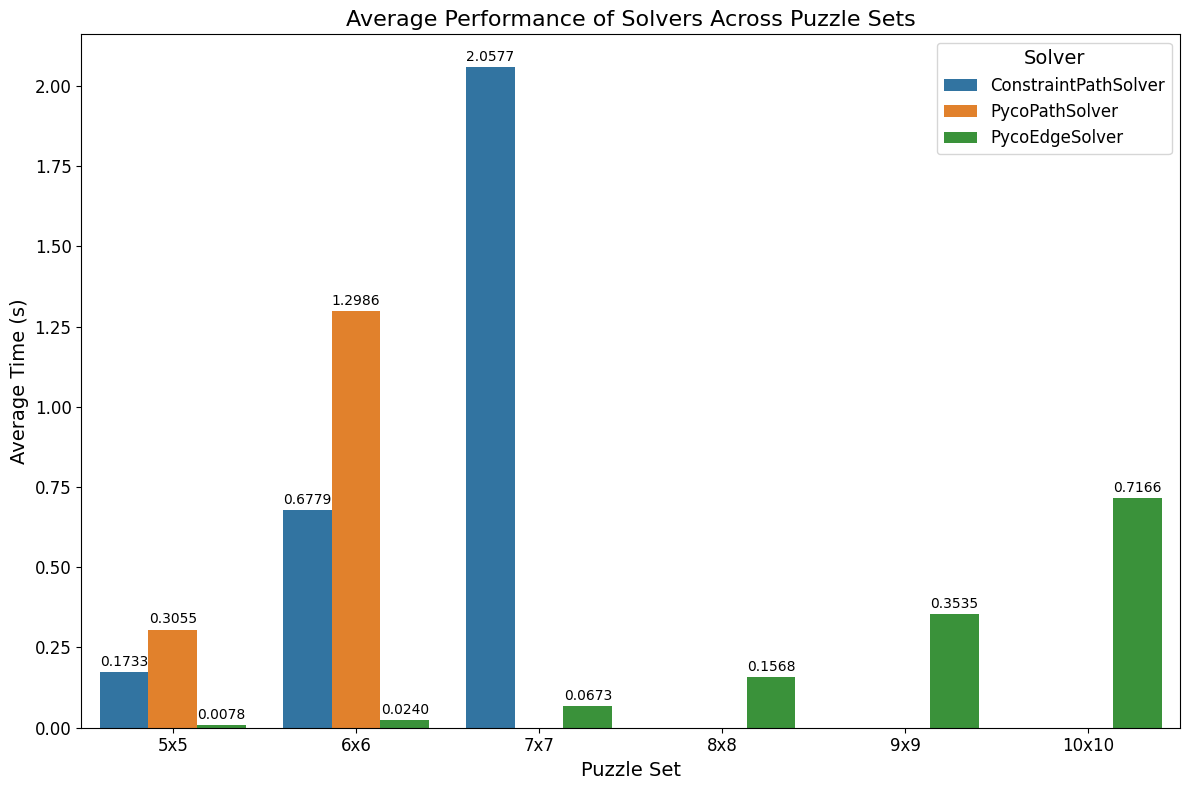

In [17]:
# Convert times from nanoseconds to seconds and round to 4 decimal places
time_df_results["Time (s)"] = (time_df_results["Time (s)"] / 1e9).round(4)

plt.figure(figsize=(12, 8)) 
ax = sns.barplot(
    x="Puzzle Set", y="Time (s)", hue="Solver", data=time_df_results, errorbar=None
)

plt.title("Average Performance of Solvers Across Puzzle Sets", fontsize=16)
plt.xlabel("Puzzle Set", fontsize=14)
plt.ylabel("Average Time (s)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Solver", fontsize=12, title_fontsize=14)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,  
            f"{height:.4f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.tight_layout() 
plt.show()

In [18]:
clauses_df_results = pd.read_csv("results.csv")

In [19]:
# Count occurrences of each combination of Solver and Puzzle Set
solver_puzzle_counts = clauses_df_results.groupby(['Solver', 'Puzzle Set']).size().reset_index(name='Count')

# Filter combinations with at least 50 occurrences
valid_combinations = solver_puzzle_counts[solver_puzzle_counts['Count'] >= 50][['Solver', 'Puzzle Set']]

# Merge the valid combinations with the original DataFrame
clauses_df_results = clauses_df_results.merge(valid_combinations, on=['Solver', 'Puzzle Set'])

In [20]:
# Only keep rows with solvers as PycoEdgeSolver and PycoPathSolver
clauses_df_results = clauses_df_results[clauses_df_results["Solver"].isin(["PycoEdgeSolver", "PycoPathSolver"])]

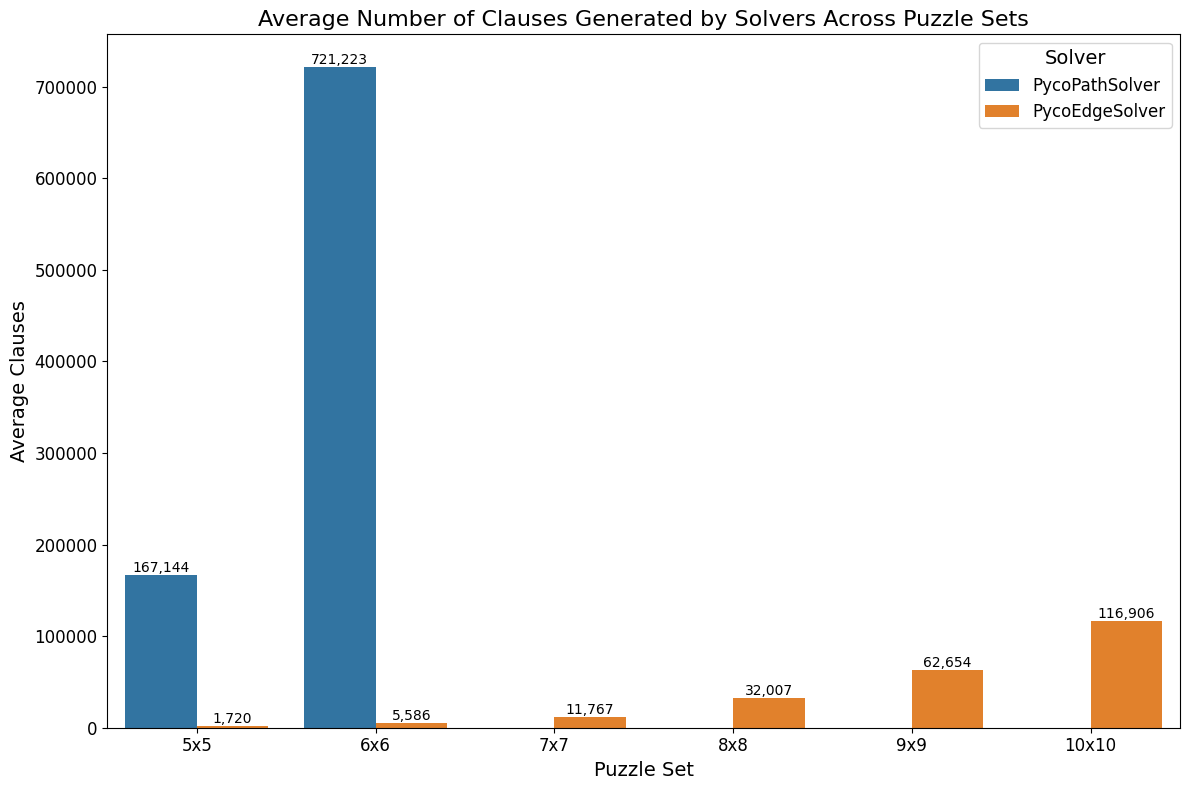

In [21]:
clauses_df_results["Puzzle Set"] = clauses_df_results["Puzzle Set"].str.extract(r'(\d+)').astype(int)
average_clauses = clauses_df_results.sort_values(by="Puzzle Set", ascending=True)

average_clauses["Puzzle Set"] = average_clauses["Puzzle Set"].astype(str) + "x" + average_clauses["Puzzle Set"].astype(str)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x="Puzzle Set", y="Clauses", hue="Solver", data=average_clauses, errorbar=None
)

plt.title("Average Number of Clauses Generated by Solvers Across Puzzle Sets", fontsize=16)
plt.xlabel("Puzzle Set", fontsize=14)
plt.ylabel("Average Clauses", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Solver", fontsize=12, title_fontsize=14)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01, 
            f"{int(height):,}",  
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.tight_layout()
plt.show()